# Mini-Project 3
**Author**: Farkhad Kuanyshkereyev<br>
**Course**: Machine Learning<br>
**Professor**: Sepinoud Azimi Rashti

## **Step 1 - Importing Packages**

In [1]:
# Upgrading pip and installing UMAP package

!pip install --upgrade pip
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Importing necessary packages

from collections import Counter
from matplotlib.lines import Line2D
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from time import perf_counter

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import umap

In [3]:
# Defining path constants

DATA_FOLDER = "./UCI HAR Dataset/"

ACTIVITIES_FILE = os.path.join(DATA_FOLDER, "activity_labels.txt")
FEATURES_FILE   = os.path.join(DATA_FOLDER, "features.txt")
X_TRAIN_FILE    = os.path.join(DATA_FOLDER, "train/X_train.txt")
Y_TRAIN_FILE    = os.path.join(DATA_FOLDER, "train/y_train.txt")

## **Step 2 - Data Processing**

In [4]:
# Defining dataset reading and plotting functions

def get_activity_labels():    
    df = pd.read_csv(ACTIVITIES_FILE, sep=' ', header=None)
    activity_labels = {k: v for k, v in df.values}
    return activity_labels

def get_feature_names():
    features_df = pd.read_csv(FEATURES_FILE, sep=' ', header=None)
    features_df.drop(columns=[0], inplace=True)
    feature_names = features_df.values.flatten().tolist()
    return feature_names

def read_dataset(txt_filepath, features):
    dataset = pd.DataFrame(columns=features)

    with open(txt_filepath) as file:
        while True:
            values = file.readline()

            if len(values) == 0:
                break

            values = values.strip().split(' ')
            values = [float(x) for x in values if len(x) != 0]
            dataset = dataset.append({k: v for k, v in zip(features, values)}, ignore_index=True)

    return dataset

def read_labels(txt_filepath):
    labels = pd.read_csv(txt_filepath, header=None)
    labels.rename(columns={0: "Label"}, inplace=True)
    labels = labels["Label"].values
    return labels

def plot_target_distribution(labels, activity_labels):
    counts = Counter(labels)
    x, height = counts.keys(), counts.values()
    x = [activity_labels[val] for val in x]
    
    plt.figure(figsize=(17, 10))
    plt.bar(x, height, color=["red", "orange", "yellow", "green", "blue", "violet"])
    plt.title("Target distribution", fontsize=18)
    plt.xlabel("Target Label", fontsize=16)
    plt.ylabel("Frequency", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.grid(axis='y')
    plt.show()

In [5]:
# Reading activity labels

activity_labels = get_activity_labels()

In [6]:
# Reading feature names

features = get_feature_names()

In [7]:
# Reading the dataset and labels (may run approximately 1 minute)

X_train = read_dataset(X_TRAIN_FILE, features)
y_train = read_labels(Y_TRAIN_FILE)

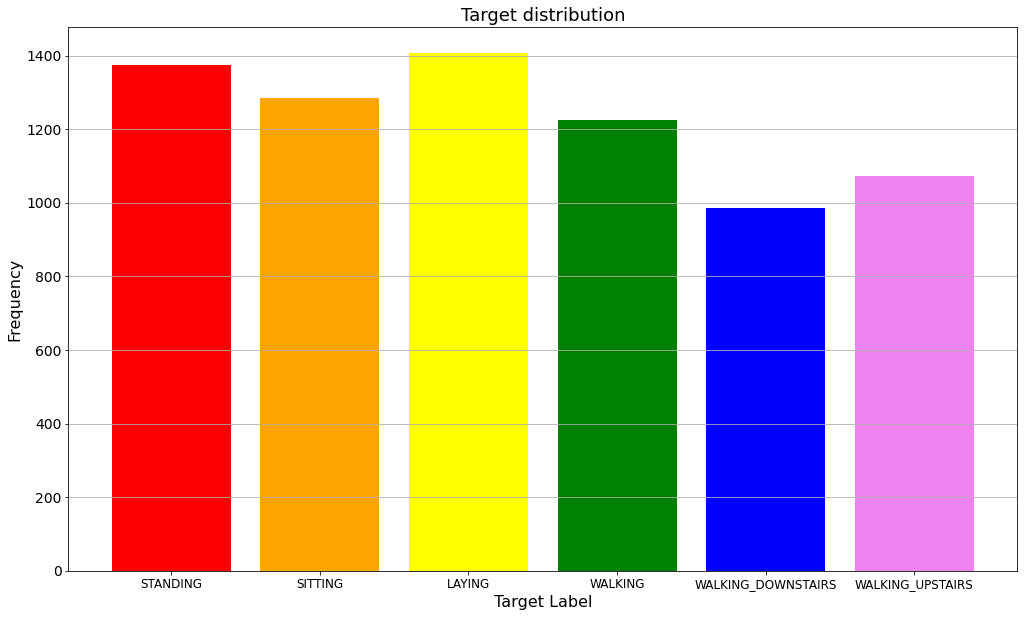

In [8]:
# Plotting the distribution of target labels

plot_target_distribution(y_train, activity_labels)

In [9]:
# Checking the number of missing values in dataset

print("Number of missing values in dataset:", X_train.isna().any().sum())

Number of missing values in dataset: 0


## **Step 3 - Clustering**

In [10]:
# Defining functions for finding optimal epsilon for the DBSCAN model

def get_nearest_distances(dataset, n_neighbors=2, show=True):
    print("\nCalculating nearest distances to neighbors...\n")
    neigh = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    neighbors = neigh.fit(dataset)

    distances, indices = neighbors.kneighbors(dataset)
    sorted_distances = np.sort(distances[:, n_neighbors-1], axis=0)
    
    if show:
        plt.figure(figsize=(8, 8))
        plt.plot(range(len(sorted_distances)), sorted_distances, c="blue", linewidth=3)
        plt.title("Nearest Neighbor Distances", fontsize=18)
        plt.xlabel("Indices", fontsize=16)
        plt.ylabel("Distance", fontsize=16)
        plt.grid()
        plt.show()
        
    return sorted_distances
    
def find_optimal_eps(dataset, start=0.5, end=5, size=20, min_samples=5):
    print("\nFinding optimal value for epsilon...\n")
    eps_range = np.linspace(start, end, size)
    max_silhouette_score, best_eps = -2, -1
    clocks = []

    for eps in eps_range:
        clusterer = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        
        time_before = perf_counter()
        y_pred = clusterer.fit_predict(dataset)
        time_after = perf_counter()
        
        clocks.append(time_after - time_before)
        
        if len(set(y_pred))-1 < 2:
            continue

        score = silhouette_score(dataset, y_pred)
        
        if score > max_silhouette_score:
            max_silhouette_score = score
            best_eps = eps

        print("Epsilon:", eps)
        print("Number of clusters:", len(set(y_pred))-1)
        print("Silhouette score:", score)
        print('*' * 80)
        
    print("DBSCAN average running time: %.2f seconds" % np.mean(clocks))
    print()
        
    return best_eps

def clustering_pipeline(dataset, eps_size=30):
    distances = get_nearest_distances(dataset, n_neighbors=MIN_SAMPLES)
    eps = find_optimal_eps(dataset, start=distances[0], end=distances[-1], size=eps_size, min_samples=MIN_SAMPLES)
    clusterer = DBSCAN(eps=eps, min_samples=MIN_SAMPLES, n_jobs=-1)
    y_pred = clusterer.fit_predict(dataset)
    
    print("\nFinished!")
    
    return y_pred

In [11]:
# Setting the minimum samples equal to the double of the number of features in the dataset

MIN_SAMPLES = X_train.shape[1] * 2

In [12]:
# Defining the dictionary of resultant clusters

predictions = {}


Calculating nearest distances to neighbors...



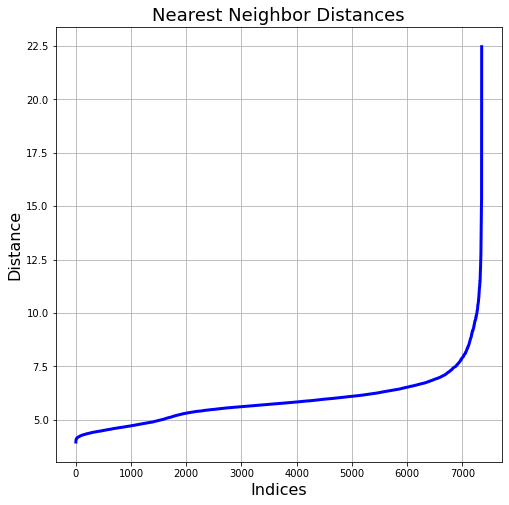


Finding optimal value for epsilon...

Epsilon: 5.235779764040987
Number of clusters: 2
Silhouette score: 0.30890605677256766
********************************************************************************
Epsilon: 5.873898784412171
Number of clusters: 2
Silhouette score: 0.41849091390266624
********************************************************************************
DBSCAN average running time: 10.62 seconds


Finished!


In [13]:
# Calculating clustering results for the original dataset (might take 1-2 minutes)

predictions["Clustering"] = clustering_pipeline(X_train)

## **Step 4 - Dimensionality Reduction & Clustering**

In [14]:
# Defining the function for calculating embeddings with 3 dimensionality reduction techniques

def get_embeddings(dataset, n_components=2):
    embedded_pca = PCA(n_components=n_components, random_state=0).fit_transform(dataset)
    embedded_umap = umap.UMAP(n_components=n_components, random_state=0, n_jobs=-1).fit_transform(dataset)
    embedded_tsne = TSNE(n_components=n_components, random_state=0, n_jobs=-1).fit_transform(dataset)
    
    embeddings = {
        "PCA": embedded_pca,
        "UMAP": embedded_umap,
        "t-SNE": embedded_tsne
    }
    
    return embeddings

In [15]:
# Calculating embeddings (might take 1-2 minutes)

embeddings = get_embeddings(X_train)

/home/faranio/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


### **Step 4.1 - PCA**


Calculating nearest distances to neighbors...



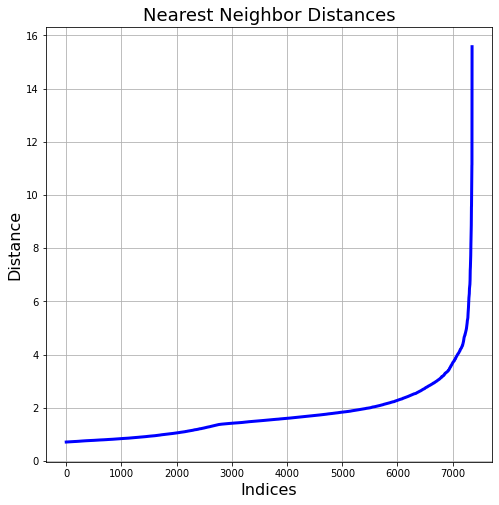


Finding optimal value for epsilon...

Epsilon: 1.7400083081450437
Number of clusters: 2
Silhouette score: 0.6357766890251483
********************************************************************************
Epsilon: 2.2522948051836567
Number of clusters: 2
Silhouette score: 0.6880772127857596
********************************************************************************
Epsilon: 2.764581302222269
Number of clusters: 2
Silhouette score: 0.7039340276280017
********************************************************************************
Epsilon: 3.2768677992608817
Number of clusters: 2
Silhouette score: 0.7100077790883922
********************************************************************************
DBSCAN average running time: 0.30 seconds


Finished!


In [16]:
# Calculating clustering results for the PCA embeddings

predictions["PCA"] = clustering_pipeline(embeddings["PCA"])

### **Step 4.2 - UMAP**


Calculating nearest distances to neighbors...



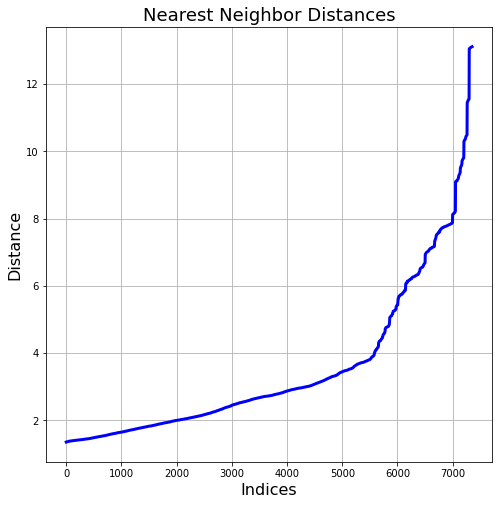


Finding optimal value for epsilon...

Epsilon: 2.1690813635428827
Number of clusters: 2
Silhouette score: 0.71238005
********************************************************************************
Epsilon: 2.574481729165136
Number of clusters: 3
Silhouette score: 0.56681204
********************************************************************************
Epsilon: 2.9798820947873894
Number of clusters: 3
Silhouette score: 0.58322257
********************************************************************************
Epsilon: 3.3852824604096425
Number of clusters: 3
Silhouette score: 0.6085548
********************************************************************************
Epsilon: 3.7906828260318957
Number of clusters: 3
Silhouette score: 0.6266476
********************************************************************************
Epsilon: 4.196083191654149
Number of clusters: 3
Silhouette score: 0.6441358
********************************************************************************
Epsilo

In [17]:
# Calculating clustering results for the UMAP embeddings

predictions["UMAP"] = clustering_pipeline(embeddings["UMAP"])

### **Step 4.3 - t-SNE**


Calculating nearest distances to neighbors...



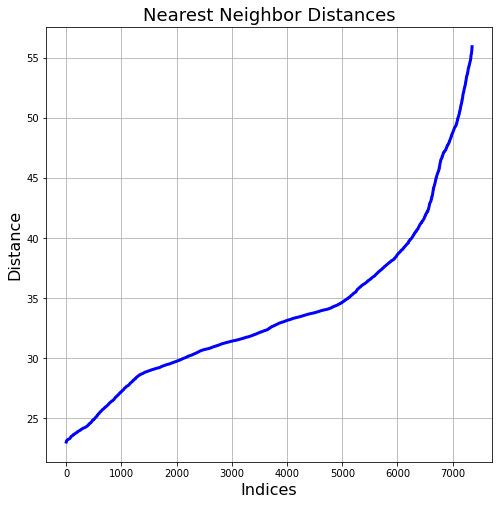


Finding optimal value for epsilon...

Epsilon: 26.441208662134002
Number of clusters: 2
Silhouette score: 0.41793928
********************************************************************************
Epsilon: 27.576042501925862
Number of clusters: 2
Silhouette score: 0.42625663
********************************************************************************
Epsilon: 28.710876341717714
Number of clusters: 3
Silhouette score: 0.35064995
********************************************************************************
Epsilon: 29.845710181509574
Number of clusters: 3
Silhouette score: 0.36126217
********************************************************************************
DBSCAN average running time: 0.17 seconds


Finished!


In [18]:
# Calculating clustering results for the t-SNE embeddings

predictions["t-SNE"] = clustering_pipeline(embeddings["t-SNE"])

## **Step 5 - Visualization**

In [19]:
# Defining the data visualization function

def data_visualization(embeddings, labels, label_names=None):
    num_embeddings = len(embeddings)
    subplot_width = 5
    
    fig, ax = plt.subplots(1, num_embeddings, figsize=(num_embeddings * subplot_width, subplot_width))

    shifted_labels = labels.copy()
    
    if min(shifted_labels) == -1:
        shifted_labels += 1
    elif min(shifted_labels) == 1:
        shifted_labels -= 1

    unique_labels = np.unique(shifted_labels)
    colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    scatter_colors = [colors[x] for x in shifted_labels]
    
    if label_names:
        patches = []

        for i in range(len(colors)):
            patch = Line2D(
                [0], 
                [0], 
                marker='o', 
                color=colors[i], 
                label=label_names[i+1], 
                markerfacecolor=colors[i], 
                markersize=5
            )
            patches.append(patch)

    for i, key in enumerate(embeddings.keys()):
        temp = ax[i].scatter(embeddings[key][:, 0], embeddings[key][:, 1], c=scatter_colors)
        ax[i].set_title(f"{key} Plot", fontsize=18)
        ax[i].set_xlabel("Projection 1", fontsize=16)
        
        if label_names:
            ax[0].legend(handles=patches)
    
    ax[0].set_ylabel("Projection 2", fontsize=16)
    plt.show()

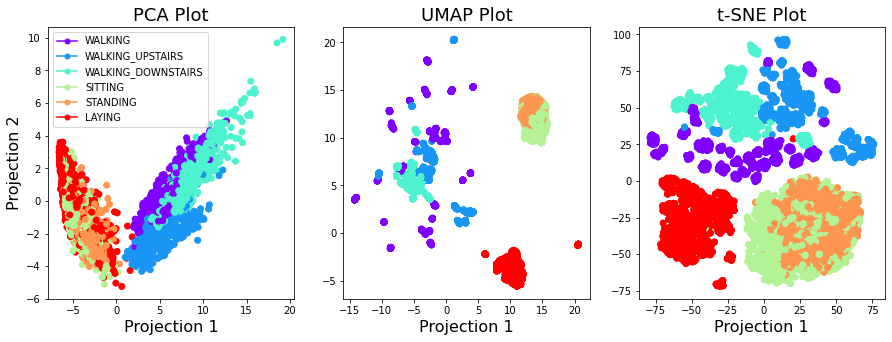

In [20]:
# Visualizing the true labels

data_visualization(embeddings, y_train, label_names=activity_labels)

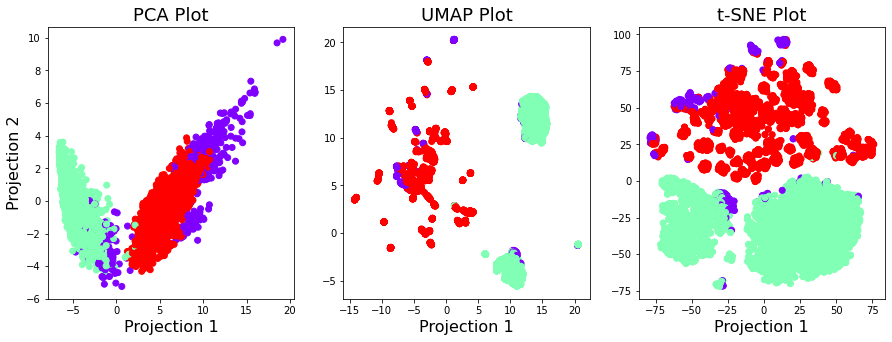

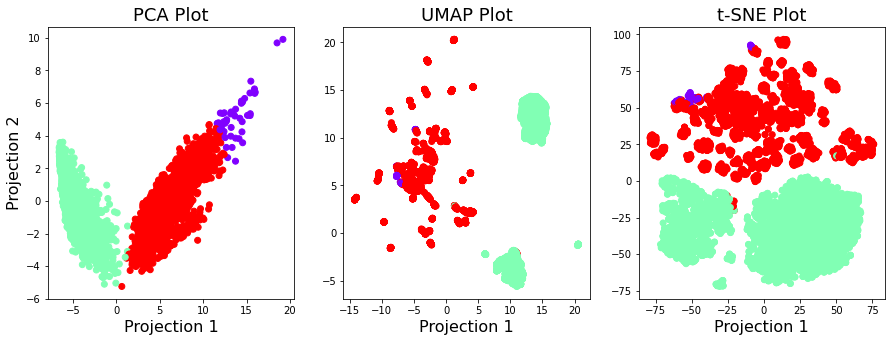

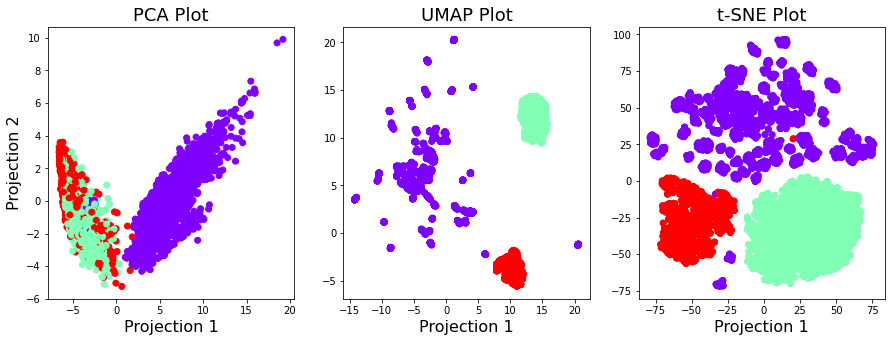

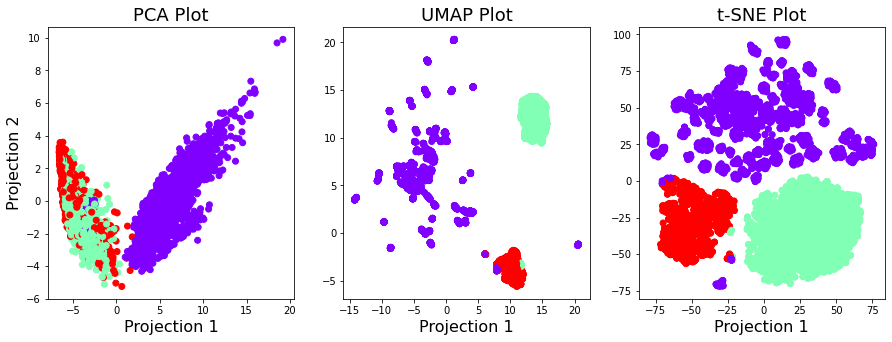

In [21]:
# Visualizing the predicted clusters

for key in predictions.keys():
    data_visualization(embeddings, predictions[key])